<a href="https://colab.research.google.com/github/gab-lacerda/EP-IA/blob/main/vers%C3%A3o_bin%C3%A1ria_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.1 MB/s eta 0:00:00


In [2]:
!rm -rf my_dir

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import keras_tuner as kt
import pickle

# Constrói modelo com vários hiperparâmetros que serão usados para encontrar o melhor modelo
def build_model(hp):
    # Sequencial, uma camada após a outra
    model = Sequential()

    # Conv2D layers
    model.add(Conv2D(
        filters=hp.Int('filters_0', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_0', values=[3, 5]),
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    # Adiciona um MaxPooling de 2x2 ou 3x3
    model.add(MaxPooling2D(pool_size=hp.Choice('pool_size_0', values=[2, 3])))

    # Adiciona de 1 a 3 camadas convolucionais extras com max pooling de 2x2 ou 3x3 e
    # filtros de 32 a 128 com tamanho de 3x3 a 5x5 e função de ativação Relu
    for i in range(1, hp.Int('conv_layers', 1, 3)):
        model.add(Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu'
        ))
        model.add(MaxPooling2D(pool_size=hp.Choice(f'pool_size_{i}', values=[2, 3])))

    model.add(Flatten())

    # Camadas densas
    for i in range(hp.Int('dense_layers', 1, 3)):
        # Adiciona uma camada densa com 64 até 256 neurônios e função de ativação Relu
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            activation='relu'
        ))
        # Adiciona o dropout que adiciona ruído na rede, isto é, desativa aleatoriamente de 20% a 50% dos neurônios para
        # melhorar a adaptabilidade da rede e não viciá-la nos dados de treinamento
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

    # Camada densa final, com 2 neurônios (´para classificar 0s e 1s) e
    # função de ativação softmax, ideal para problemas de classificação
    model.add(Dense(2, activation='softmax'))

    # Compila o modelo
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', ])

    return model








# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Filtra o dataset para somente os dígitos 0 e 1
train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]

# Redimensionar as imagens para incluir a dimensão do canal
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalizar os valores dos pixels para o intervalo [0, 1]
X_train /= 255
X_test /= 255

# Converter os rótulos para o formato one-hot encoding
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

# Separa o treinamento em dois: treinamento e validação
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)














# Definição da busca por melhores hiperparâmetros
tuner = kt.Hyperband(build_model,
                    objective='val_accuracy',
                    max_epochs=10,
                    factor=3,
                    directory='my_dir',
                    project_name='intro_to_kt')

#definição de parada antecipada
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Executar a busca de hiperparâmetros
tuner.search(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), batch_size=200, verbose=1, callbacks=[stop_early])

# Obter os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Melhores hiperparâmetros: {best_hps.values}")

Trial 23 Complete [00h 00m 00s]

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 16m 13s
Melhores hiperparâmetros: {'filters_0': 64, 'kernel_size_0': 5, 'pool_size_0': 2, 'conv_layers': 2, 'dense_layers': 2, 'units_0': 128, 'dropout_0': 0.30000000000000004, 'filters_1': 96, 'kernel_size_1': 5, 'pool_size_1': 2, 'units_1': 256, 'dropout_1': 0.2, 'filters_2': 32, 'kernel_size_2': 3, 'pool_size_2': 3, 'units_2': 192, 'dropout_2': 0.30000000000000004, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [4]:
# Constrói o modelo com os melhores hiperparâmetros por 50 épocas
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, batch_size=200, verbose=1)

# Identifica a época com a melhor acurácia
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
51/51 [==============================] - 23s 428ms/step - loss: 0.1947 - accuracy: 0.9461 - val_loss: 0.0046 - val_accuracy: 0.9984
Epoch 2/50
51/51 [==============================] - 20s 393ms/step - loss: 0.0094 - accuracy: 0.9976 - val_loss: 8.9806e-04 - val_accuracy: 1.0000
Epoch 3/50
51/51 [==============================] - 21s 412ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 4.0549e-04 - val_accuracy: 1.0000
Epoch 4/50
51/51 [==============================] - 20s 392ms/step - loss: 0.0026 - accuracy: 0.9988 - val_loss: 3.0885e-04 - val_accuracy: 1.0000
Epoch 5/50
51/51 [==============================] - 21s 419ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 2.0753e-04 - val_accuracy: 1.0000
Epoch 6/50
51/51 [==============================] - 20s 393ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 2.1912e-04 - val_accuracy: 1.0000
Epoch 7/50
51/51 [==============================] - 21s 423ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 7.9674e-0

Epoch 1/2
51/51 [==============================] - 23s 421ms/step - loss: 0.2081 - accuracy: 0.9551 - val_loss: 0.0012 - val_accuracy: 0.9996
Epoch 2/2
51/51 [==============================] - 20s 393ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 3.5914e-04 - val_accuracy: 1.0000
Test loss: 0.0023907399736344814
Test accuracy: 0.9990543723106384
67/67 [==============================] - 1s 16ms/step


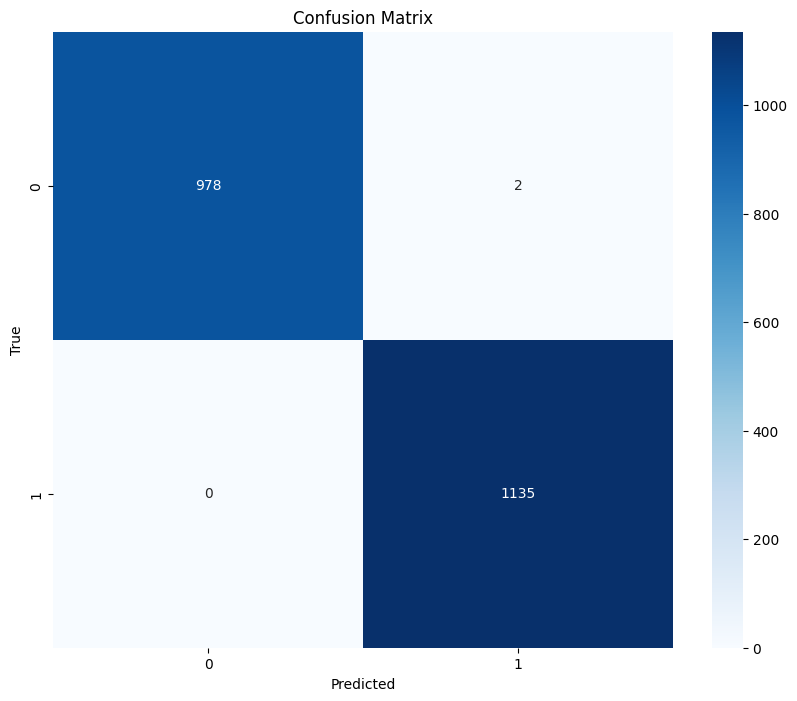

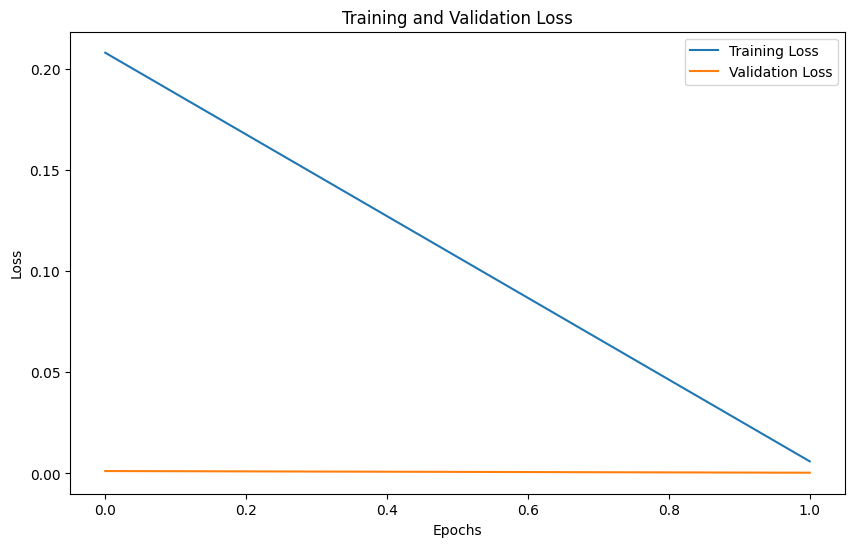

In [8]:
# Cria o modelo com os melhores hiperparâmetros novamente
model = tuner.hypermodel.build(best_hps)

# Guardar os pesos iniciais
initial_weights = [layer.get_weights() for layer in model.layers]

# Retreinar o modelo com a quantidade de épocas ideais
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=best_epoch, batch_size=200, verbose=1)

# Avaliar o modelo
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Guardar os pesos finais
final_weights = [layer.get_weights() for layer in model.layers]

# Prever os rótulos para os dados de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Plotar a matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plotar o gráfico de loss do treinamento
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Salvar hiperparâmetros e pesos

hyperparameters = best_hps

# Salvar hiperparâmetros
with open('hyperparameters.pkl', 'wb') as f:
    pickle.dump(hyperparameters, f)

# Salvar pesos iniciais
with open('initial_weights.pkl', 'wb') as f:
    pickle.dump(initial_weights, f)

# Salvar pesos finais
with open('final_weights.pkl', 'wb') as f:
    pickle.dump(final_weights, f)

# Salvar histórico do treinamento (erro por iteração)
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Salvar as saídas da rede neural para os dados de teste
with open('test_predictions.pkl', 'wb') as f:
    pickle.dump(y_pred, f)